In [2]:
import pandas as pd
from prophet import Prophet


In [122]:
#dtype = {'date': 'datetime'}

df = pd.read_csv('../clean_data/crado_velo.csv', dtype=str)


In [123]:
df.head()


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,lat,long,dep
0,201800050213,18,1,20,1300,1,2,2,2.0,6.0,101.0,"12, QUAI FRANCOIS MITTER",4886010.0,233333.0,750
1,201800050217,18,1,30,1835,5,2,2,1.0,3.0,101.0,RUE ETIENNE MARCEL,4886530.0,234307.0,750
2,201800050225,18,2,19,1620,1,2,3,8.0,6.0,101.0,"224, RUE DE RIVOLI",4886530.0,232728.0,750
3,201800050240,18,4,6,1540,1,2,2,1.0,3.0,101.0,"172, RUE DE RIVOLI",4886270.0,233525.0,750
4,201800050241,18,4,12,1205,1,2,1,1.0,6.0,101.0,QUAI DES TUILERIES,4886230.0,232551.0,750


In [124]:
df['lat'] = df['lat'].apply(lambda x: str(int(float(x))) if x.replace('.', '', 1).lstrip('-').isdigit() and x.endswith('.0') else x)
df['long'] = df['long'].apply(lambda x: str(int(float(x))) if x.replace('.', '', 1).lstrip('-').isdigit() and x.endswith('.0') else x)


In [125]:
def reformatter_lat_lon(dataframe):
    """
    Reformate les colonnes de latitude et de longitude d'une DataFrame Pandas,
    en remplaçant les virgules par des points et en assurant que les valeurs sont dans un format décimal correct.
    """

    if 'lat' in dataframe.columns and 'long' in dataframe.columns:
        for col in ['lat', 'long']:
            dataframe[col] = dataframe[col].str.replace(',', '.')
    else:
        raise ValueError("La DataFrame doit contenir les colonnes 'lat' et 'long'")

    return dataframe


In [126]:
reformatter_lat_lon(df)


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,lat,long,dep
0,201800050213,18,1,20,1300,1,2,2,2.0,6.0,101.0,"12, QUAI FRANCOIS MITTER",4886010,233333,750
1,201800050217,18,1,30,1835,5,2,2,1.0,3.0,101.0,RUE ETIENNE MARCEL,4886530,234307,750
2,201800050225,18,2,19,1620,1,2,3,8.0,6.0,101.0,"224, RUE DE RIVOLI",4886530,232728,750
3,201800050240,18,4,6,1540,1,2,2,1.0,3.0,101.0,"172, RUE DE RIVOLI",4886270,233525,750
4,201800050241,18,4,12,1205,1,2,1,1.0,6.0,101.0,QUAI DES TUILERIES,4886230,232551,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14318,201500056062,15,12,7,1809,5,2,7,1.0,3.0,108.0,PLACE DU HAVRE,48.875384,2.326912,750
14319,201500056076,15,12,18,1600,1,2,3,1.0,3.0,115.0,"33 bis, RUE MADEMOISELLE",48.843718,2.296738,750
14320,201500056078,15,12,18,2159,5,2,2,1.0,3.0,105.0,"26, BOULEVARD SAINT MICH",48.865803,2.275852,750
14321,201500056079,15,12,20,1930,5,2,7,1.0,3.0,109.0,PLACE PIGALLE,48.882028,2.33727,750


In [127]:
df['long'] = df['long'].apply(lambda x: x[:1] + '.' + x[1:] if '.' not in x else x)
df['lat'] = df['lat'].apply(lambda x: x[:2] + '.' + x[2:] if '.' not in x else x)


In [128]:
df.head()


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,lat,long,dep
0,201800050213,18,1,20,1300,1,2,2,2.0,6.0,101.0,"12, QUAI FRANCOIS MITTER",48.86010,2.33333,750
1,201800050217,18,1,30,1835,5,2,2,1.0,3.0,101.0,RUE ETIENNE MARCEL,48.86530,2.34307,750
2,201800050225,18,2,19,1620,1,2,3,8.0,6.0,101.0,"224, RUE DE RIVOLI",48.86530,2.32728,750
3,201800050240,18,4,6,1540,1,2,2,1.0,3.0,101.0,"172, RUE DE RIVOLI",48.86270,2.33525,750
4,201800050241,18,4,12,1205,1,2,1,1.0,6.0,101.0,QUAI DES TUILERIES,48.86230,2.32551,750


In [129]:
df['lat'].value_counts()


48.861254        94
48.862172        78
48.865803        43
48.865705        35
48.840153        34
                 ..
48.8872310000     1
48.9007550000     1
48.8551680000     1
48.8372920000     1
48.882028         1
Name: lat, Length: 9676, dtype: int64

In [130]:
df['hrmn'] = df['hrmn'].str.replace(':', '')


In [131]:
def process_dates(df):
    # # Vérifier les dates invalides
    # invalid_dates = df[(df['jour'] > 31) | ((df['mois'] == 2) & (df['jour'] > 29)) | ((df['mois'].isin([4, 6, 9, 11])) & (df['jour'] > 30))]
    # df = df.drop(invalid_dates.index)

    # Créer la colonne 'date'
    df['date'] = pd.to_datetime(df['an'].astype(str).str.zfill(2)
                                + df['mois'].astype(str).str.zfill(2)
                                + df['jour'].astype(str).str.zfill(2)
                                + df['hrmn'].astype(str).str.zfill(4),
                                format='%y%m%d%H%M', errors='coerce')

    df = df.drop(columns=['an', 'mois', 'jour', 'hrmn'])
    return df


In [136]:
df = process_dates(df)


In [137]:
df.head()


,Num_Acc,lum,agg,int,atm,col,com,adr,lat,long,dep,date
0,201800050213,1,2,2,2.0,6.0,101.0,"12, QUAI FRANCOIS MITTER",48.86010,2.33333,750,2018-01-20 13:00:00
1,201800050217,5,2,2,1.0,3.0,101.0,RUE ETIENNE MARCEL,48.86530,2.34307,750,2018-01-30 18:35:00
2,201800050225,1,2,3,8.0,6.0,101.0,"224, RUE DE RIVOLI",48.86530,2.32728,750,2018-02-19 16:20:00
3,201800050240,1,2,2,1.0,3.0,101.0,"172, RUE DE RIVOLI",48.86270,2.33525,750,2018-04-06 15:40:00
4,201800050241,1,2,1,1.0,6.0,101.0,QUAI DES TUILERIES,48.86230,2.32551,750,2018-04-12 12:05:00


In [138]:
df.to_csv('../clean_data/crado_velo_format.csv', index=False)


In [139]:
df = pd.read_csv('../clean_data/crado_velo_format.csv', dtype=str)


In [140]:
df.head()


,Num_Acc,lum,agg,int,atm,col,com,adr,lat,long,dep,date
0,201800050213,1,2,2,2.0,6.0,101.0,"12, QUAI FRANCOIS MITTER",48.86010,2.33333,750,2018-01-20 13:00:00
1,201800050217,5,2,2,1.0,3.0,101.0,RUE ETIENNE MARCEL,48.86530,2.34307,750,2018-01-30 18:35:00
2,201800050225,1,2,3,8.0,6.0,101.0,"224, RUE DE RIVOLI",48.86530,2.32728,750,2018-02-19 16:20:00
3,201800050240,1,2,2,1.0,3.0,101.0,"172, RUE DE RIVOLI",48.86270,2.33525,750,2018-04-06 15:40:00
4,201800050241,1,2,1,1.0,6.0,101.0,QUAI DES TUILERIES,48.86230,2.32551,750,2018-04-12 12:05:00


In [141]:
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date': 'ds'})


In [142]:
df['day'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['ds'] = df['ds'].dt.date


In [143]:
df = (df.groupby([df['day'], df['month'], df['year']])
  .agg({'ds': 'first','Num_Acc' : 'count'})
  .reset_index()
  .drop(columns=['day', 'month', 'year'])
  .rename(columns={'Num_Acc': 'y'})
)


In [144]:
m = Prophet()
m.fit(df)


11:28:24 - cmdstanpy - INFO - Chain [1] start processing
11:28:25 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
future = m.make_future_dataframe(periods=3000)
future.tail()


,ds
8353,2031-03-14
8354,2031-03-15
8355,2031-03-16
8356,2031-03-17
8357,2031-03-18


In [146]:
forecast_df = m.predict(future)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
8353,2031-03-14,4.985180,3.150324,7.030292
8354,2031-03-15,4.491972,2.373580,6.343010
8355,2031-03-16,4.266259,2.470464,6.124231
8356,2031-03-17,4.770475,2.648917,6.862517
8357,2031-03-18,5.103636,3.150832,7.230985


In [147]:
forecast_df.columns


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

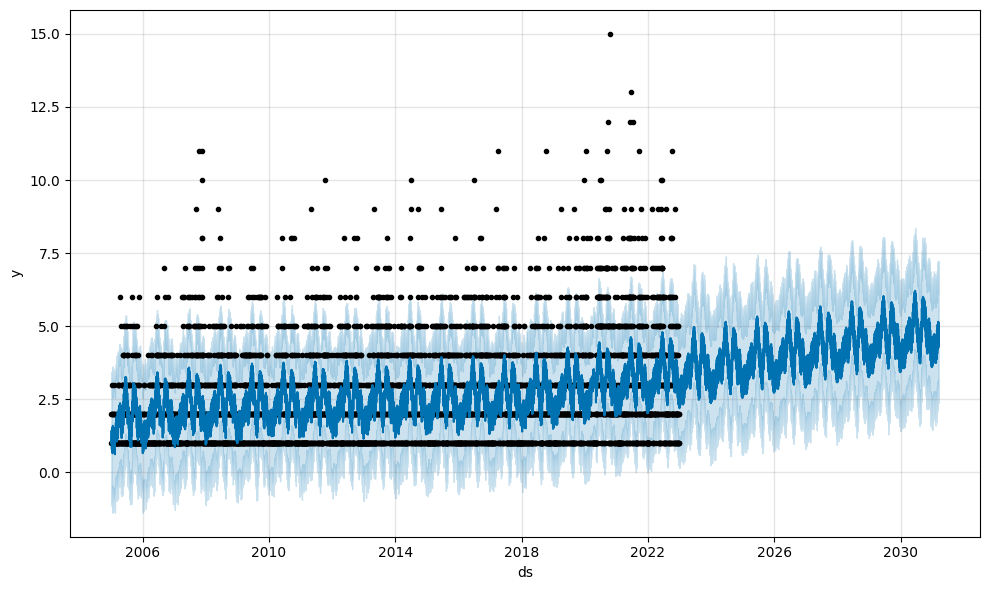

In [148]:
fig1 = m.plot(forecast_df)


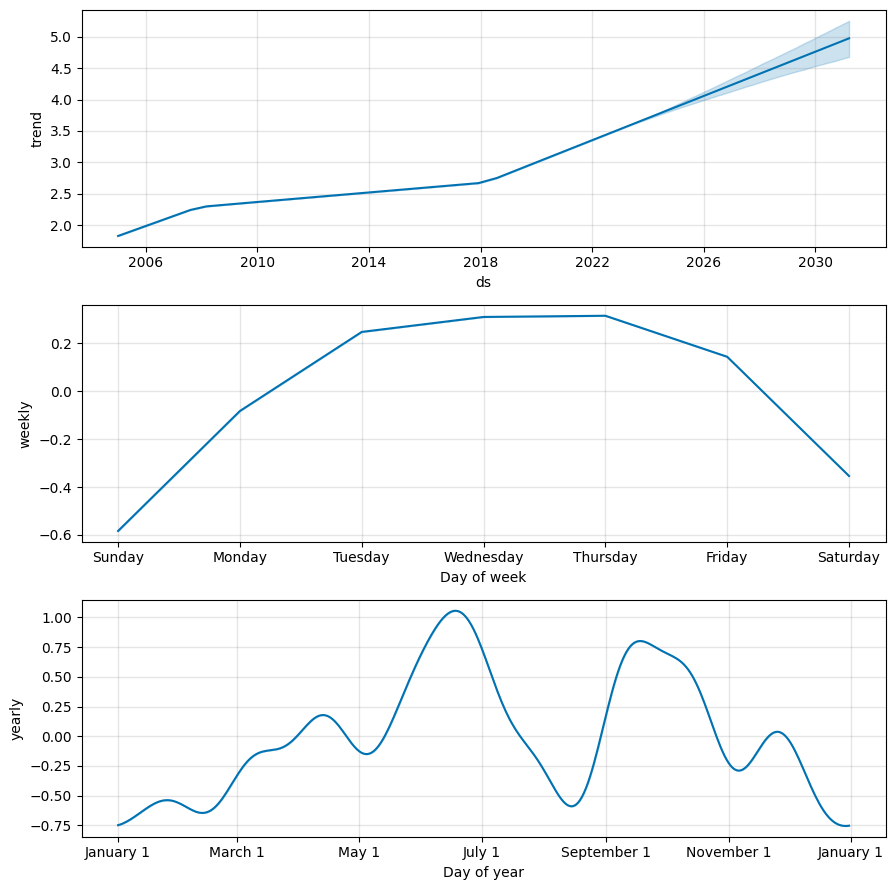

In [149]:
fig2 = m.plot_components(forecast_df);


In [150]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast_df)


In [151]:
plot_components_plotly(m, forecast_df)


In [152]:
def predict_n_accidents(d: str, model=m) -> float:
    """
    Takes a date and returns the expected number of accident for this given day.
    """
    _df = pd.DataFrame({'ds': [pd.to_datetime(d).date()]})
    return round(model.predict(_df)['yhat'][0], 2)


In [153]:
predict_n_accidents('2030-11-4')


4.55